# quant-econ Solutions: Search with Unknown Offer Distribution

Solutions for http://quant-econ.net/jl/odu.html

In [1]:
using QuantEcon
include("odu.jl")
using Plots
pyplot()
using Interpolations

## Exercise 1

This code solves the "Offer Distribution Unknown" model by iterating on a guess of the reservation wage function. You should find that the run time is much shorter than that of the value function approach in `examples/odu_vfi_plots.jl`

Compute iterate 10 with error 0.007194437603255555
Converged in 18 steps
[Plots.jl] Initializing backend: pyplot


2016-08-10 14:24:26.650 julia[6830:507] setCanCycle: is deprecated.  Please use setCollectionBehavior instead



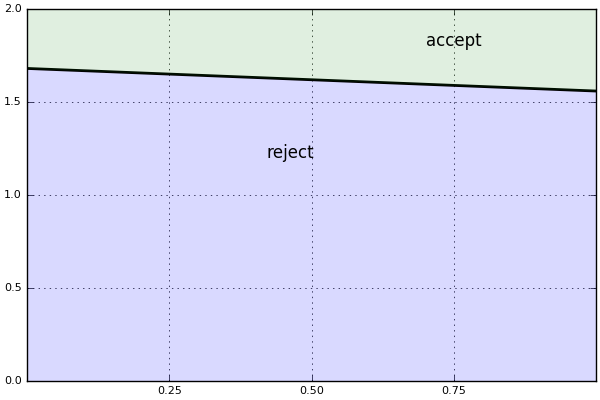

In [2]:
sp = SearchProblem(pi_grid_size=50)

phi_init = ones(sp.n_pi) 
f(x) = res_wage_operator(sp, x)
w_bar = compute_fixed_point(f, phi_init)

plot(sp.pi_grid, w_bar, linewidth=2, color=:black,
fill_between=0, fillalpha=0.15, fillcolor=:blue)
plot!(sp.pi_grid, 2*ones(length(w_bar)), linewidth=0, fill_between=w_bar, 
fillalpha=0.12, fillcolor=:green, legend=:none)
plot!(ylims=(0, 2), annotations=[(0.42, 1.2, "reject") (0.7, 1.8, "accept")]')


The next piece of code is not one of the exercises from quant-econ, it's just a fun simulation to see what the effect of a change in the underlying distribution on the unemployment rate is.

At a point in the simulation, the distribution becomes significantly worse. It takes a while for agents to learn this, and in the meantime they are too optimistic, and turn down too many jobs. As a result, the unemployment rate spikes.

The code takes a few minutes to run.

Compute iterate 10 with error 0.007194437603255555
Converged in 18 steps
date = 20
date = 40
date = 60
date = 80
date = 100
date = 120
date = 140
date = 160
date = 180
date = 200
date = 220
date = 240
date = 260
date = 280
date = 300
date = 320
date = 340
date = 360
date = 380
date = 400
date = 420
date = 440
date = 460
date = 480
date = 500
date = 520
date = 540
date = 560
date = 580
date = 600



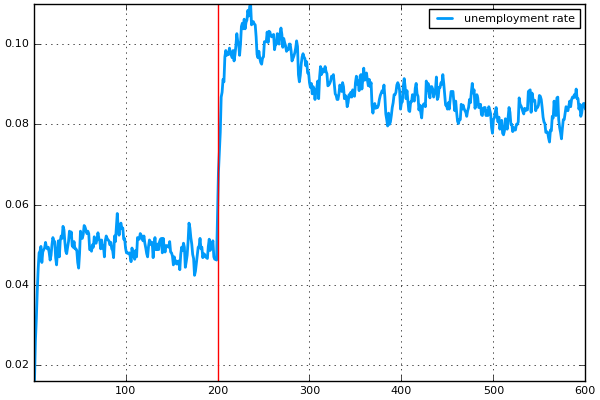

In [3]:
# Set up model and compute the function w_bar
sp = SearchProblem(pi_grid_size=50, F_a=1, F_b=1)
phi_init = ones(sp.n_pi) 
g(x) = res_wage_operator(sp, x)
w_bar_vals = compute_fixed_point(g, phi_init)
w_bar = extrapolate(interpolate((sp.pi_grid, ), w_bar_vals, 
                    Gridded(Linear())), Flat())

# Holds the employment state and beliefs of an individual agent.
type Agent  
    _pi
    employed
end

Agent(_pi=1e-3) = Agent(_pi, 1)

function update!(ag::Agent, H)
    if ag.employed == 0
        w = rand(H) * 2  # account for scale in python
        if w >= w_bar[ag._pi]
            ag.employed = 1
        else
            ag._pi = 1.0 ./ (1 .+ ((1 - ag._pi) .* sp.g(w)) ./ (ag._pi * sp.f(w)))
        end
    end
    nothing
end

num_agents = 5000
separation_rate = 0.025  # Fraction of jobs that end in each period
separation_num = round(Int, num_agents * separation_rate)
agent_indices = collect(1:num_agents)
agents = [Agent() for i=1:num_agents]
sim_length = 600
H = sp.G  # Start with distribution G
change_date = 200  # Change to F after this many periods
unempl_rate = Array(Float64, sim_length)

for i=1:sim_length
    if i % 20 == 0
        println("date = $i")
    end
    
    if i == change_date
        H = sp.F
    end
    
    # Randomly select separation_num agents and set employment status to 0
    shuffle!(agent_indices)
    separation_list = agent_indices[1:separation_num]
    
    for agent in agents[separation_list]
        agent.employed = 0
    end
    
    # update agents
    for agent in agents
        update!(agent, H)
    end
    employed = Int[agent.employed for agent in agents]
    unempl_rate[i] = 1.0 - mean(employed)
end

plot(unempl_rate, linewidth=2, label="unemployment rate")
vline!([change_date], color=:red, label="")
